In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import patient_id_age, heart_rate, create_index

# change to your folder path
# os.chdir('C:/Users/xiao-zy19/Desktop/Johns Hopkins/Biomedical Data Design/EICU Database/eicu-collaborative-research-database-demo-2.0.1')
os.chdir('/Users/xiao-zy19/Desktop/Johns Hopkins/Biomedical Data Design/EICU Database/eicu-collaborative-research-database-demo-2.0.1') 

# get patient id
patient_id, patient_age, patient_offset = patient_id_age()
# extract heart rate data
HR, _ = heart_rate(patient_id, drop_neg=True)

Loading Heart Rate Data...
Heart Rate Data Loaded. Time: 2.12s


In [27]:
print(f'Heartrate data shape: {HR.shape}')
# print(f'HR_index shape: {HR_index.shape}')
print(patient_offset)

Heartrate data shape: (814892, 3)
      patientunitstayid  unitdischargeoffset
2                143870                  793
13               151179                 4904
15               151900                 3460
16               152954                 4224
17               153972                 1545
...                 ...                  ...
2505            3346187                 2120
2509            3348292                10185
2511            3348409                 1895
2514            3351297                 1490
2517            3352231                 1369

[915 rows x 2 columns]


In [28]:
patient_hours = patient_offset.copy().reset_index(drop=True)
patient_hours['unitdischargeoffset'] = np.floor(patient_hours['unitdischargeoffset']/60).astype(int)
print(patient_hours)

     patientunitstayid  unitdischargeoffset
0               143870                   13
1               151179                   81
2               151900                   57
3               152954                   70
4               153972                   25
..                 ...                  ...
910            3346187                   35
911            3348292                  169
912            3348409                   31
913            3351297                   24
914            3352231                   22

[915 rows x 2 columns]


In [29]:
unique_HR_patient_ids = HR['patientunitstayid'].unique()
patient_hours = patient_hours[patient_hours['patientunitstayid'].isin(unique_HR_patient_ids)].reset_index(drop=True)
print(patient_hours)
print(patient_hours.loc[patient_hours["patientunitstayid"]==186393])

     patientunitstayid  unitdischargeoffset
0               143870                   13
1               151179                   81
2               151900                   57
3               152954                   70
4               153972                   25
..                 ...                  ...
907            3346187                   35
908            3348292                  169
909            3348409                   31
910            3351297                   24
911            3352231                   22

[912 rows x 2 columns]
    patientunitstayid  unitdischargeoffset
17             186393                   97


In [30]:
HR_hour_buf = HR.copy().reset_index(drop=True)
HR_hour_buf["observationoffset"] = np.floor(HR_hour_buf["observationoffset"]/60).astype(int)
# print(HR_hour_buf.loc[HR_hour_buf["patientunitstayid"]==186393])
HR_hour_buf = HR_hour_buf.groupby(["patientunitstayid", "observationoffset"], as_index=False)["heartrate"].mean()
HR_hour_buf.sort_values(by=["patientunitstayid", "observationoffset"], inplace=True)
# print(HR_hour_buf.loc[HR_hour_buf["patientunitstayid"]==186393])

HR_hour_cleaned = pd.merge(HR_hour_buf, patient_hours,on='patientunitstayid', how='left')
# print(HR_hour_cleaned.loc[HR_hour_cleaned["patientunitstayid"]==186393])
HR_hour_cleaned = HR_hour_cleaned[HR_hour_cleaned['observationoffset'] <= HR_hour_cleaned['unitdischargeoffset']]
# print(HR_hour_cleaned.loc[HR_hour_cleaned["patientunitstayid"]==186393])
HR_hour = HR_hour_cleaned.drop(['unitdischargeoffset'], axis=1)
# print(HR_hour)
# print(HR_hour.loc[HR_hour["patientunitstayid"]==186393])

In [31]:
max_offset_per_patient = HR_hour.groupby('patientunitstayid')['observationoffset'].max().reset_index()
# print(max_offset_per_patient)

complete_ranges = []
for index, row in max_offset_per_patient.iterrows():
    patient_id = row['patientunitstayid']
    max_offset = row['observationoffset']
    complete_range = pd.DataFrame({
        'patientunitstayid': patient_id,
        'observationoffset': range(int(max_offset) + 1)
    })
    complete_ranges.append(complete_range)

complete_df = pd.concat(complete_ranges, ignore_index=True)
HR_full = pd.merge(complete_df, HR_hour, on=['patientunitstayid', 'observationoffset'], how='left')

HR_full_index = create_index(HR_full)
print(HR_full_index)

0          0
1         14
2         96
3        154
4        225
       ...  
908    64978
909    65148
910    65180
911    65205
912    65219
Length: 913, dtype: int64


Finish 6th patient


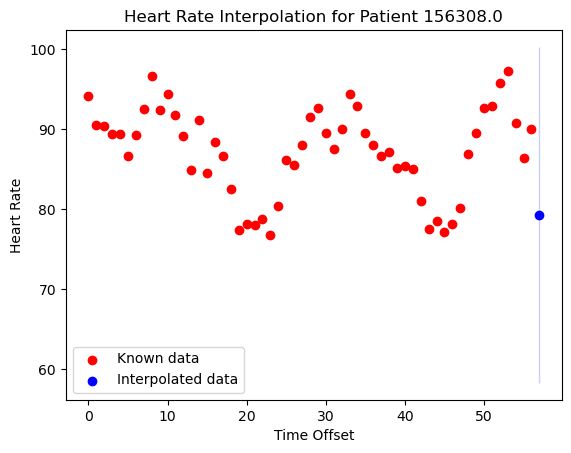

Finish 7th patient


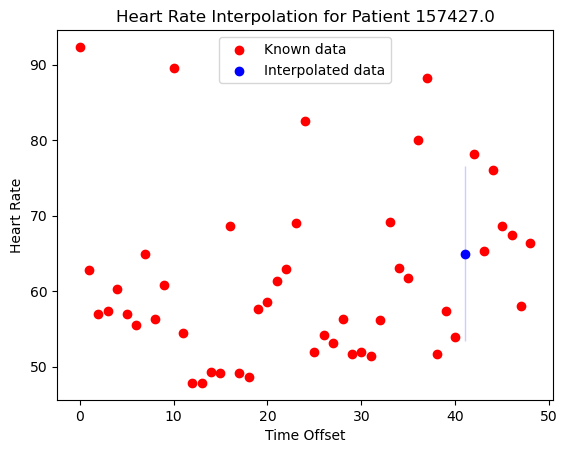

Finish 11th patient


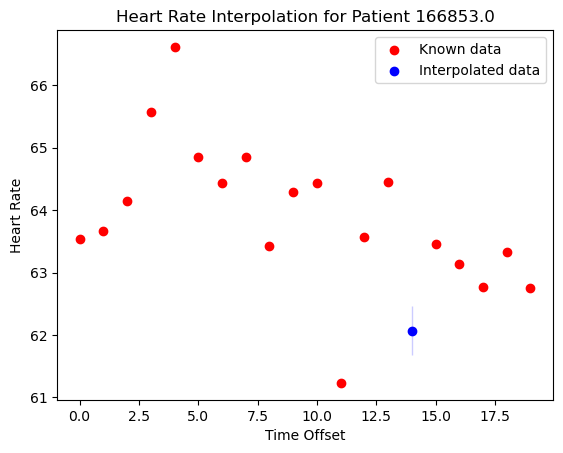

Finish 17th patient


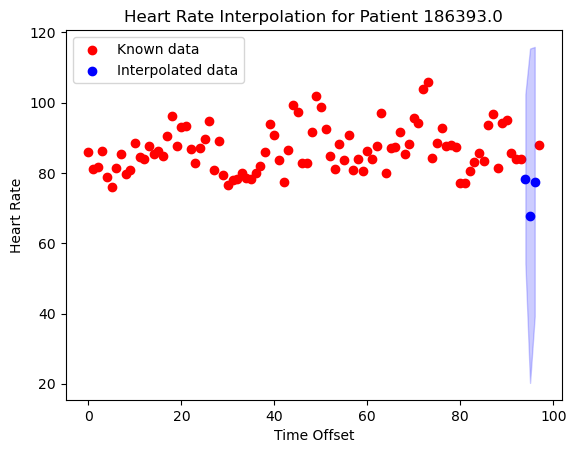

Finish 18th patient


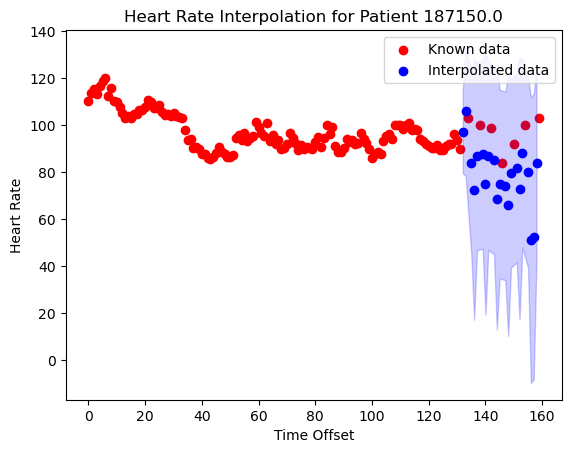

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

for i in range(len(HR_full_index)-1):
    if HR_full.iloc[HR_full_index[i]:HR_full_index[i+1]].isnull().values.any() and i < 20: # test:  i < 10
        HR_data = HR_full.iloc[HR_full_index[i]:HR_full_index[i+1]][['observationoffset', 'heartrate']].to_numpy()
        HR_id = HR_full.iloc[HR_full_index[i]:HR_full_index[i+1]]['patientunitstayid'].unique()[0]
        # print(HR_id)
        # print(i)
        t = HR_data[:, 0]
        y = HR_data[:, 1]
        
        t_known = t[~np.isnan(y)]
        y_known = y[~np.isnan(y)]
        # print(t_known, y_known)
        
        # kernel
        kernel = C(1.0) * RBF(10)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1000)
        gp.fit(t_known.reshape(-1, 1), y_known)
        t_missing = t[np.isnan(y)]
        # print(t_missing)

        y_pred, sigma = gp.predict(t_missing.reshape(-1, 1), return_std=True)
        inter_data = pd.DataFrame({'patientunitstayid': HR_id, 'observationoffset': t_missing, 'heartrate': y_pred})
        
        for idx, row in inter_data.iterrows():
            mask = (HR_full['patientunitstayid'] == row['patientunitstayid']) & (HR_full['observationoffset'] == row['observationoffset']) & HR_full['heartrate'].isnull()
            HR_full.loc[mask, 'heartrate'] = row['heartrate']
        
        print(f'Finish {i}th patient')
        
    # 绘制原始数据点
        plt.scatter(t_known, y_known, color='red', label='Known data')

        # 绘制插值数据
        plt.scatter(t_missing, y_pred, color='blue', label='Interpolated data')

        # 可选：绘制不确定性区间
        plt.fill_between(t_missing, y_pred - sigma, y_pred + sigma, alpha=0.2, color='blue')

        plt.title(f'Heart Rate Interpolation for Patient {HR_id}')
        plt.xlabel('Time Offset')
        plt.ylabel('Heart Rate')
        plt.legend()
        plt.show()
        # print(HR_full.iloc[HR_full_index[i]:HR_full_index[i+1]])

In [33]:
print(f'GaussianProcess finished!')
print(HR_full)

GaussianProcess finished!
       patientunitstayid  observationoffset  heartrate
0               143870.0                  0  41.562500
1               143870.0                  1  41.428571
2               143870.0                  2  43.307692
3               143870.0                  3  44.923077
4               143870.0                  4  47.846154
...                  ...                ...        ...
65214          3352231.0                  9  72.307692
65215          3352231.0                 10  62.538462
65216          3352231.0                 11  58.071429
65217          3352231.0                 12  57.285714
65218          3352231.0                 13  67.272727

[65219 rows x 3 columns]
